In [2]:
import tensorflow as tf
from tensorflow import keras 
from skimage import color
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

In [68]:

dataset = np.load('/Users/mac/Dev/Project/ThermalCamera/Model/Custom/Datasets/roboflow/train/dataset.npz')


origin_images, target_images, number_labels = dataset['images'], dataset['filters'], dataset['numbers']


print(origin_images.shape)
print(target_images.shape)
print(number_labels.shape)


(6609, 24, 32)
(6609, 24, 32)
(6609,)


In [69]:
origin_images = origin_images.reshape(6609, 24, 32, 1)
target_images = target_images.reshape(6609, 24, 32, 1)
print(origin_images.shape)
print(target_images.shape)

(6609, 24, 32, 1)
(6609, 24, 32, 1)


In [70]:
print(origin_images.max(), origin_images.min())
print(target_images.max(), target_images.min())

origin_images = origin_images / origin_images.max()
target_images = target_images / target_images.max()

print(origin_images.max(), origin_images.min())
print(target_images.max(), target_images.min())

255 0
255 0
1.0 0.0
1.0 0.0


(7, 48, 32, 1)


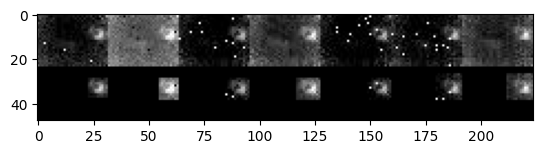

[1 1 1 1 1 1 1]
[ 246  247  248 ... 6606 6607 6608]


In [54]:
imgs = np.concatenate([origin_images[6601:6608], target_images[6601:6608]], axis = 1)
print(imgs.shape)

plt.imshow(imgs.transpose(1, 0, 2, 3).reshape(48, -1, 1), cmap = 'gray')
plt.show()
print(number_labels[6601:6608])

indices = np.argwhere(number_labels == 1).flatten()
print(indices)

In [55]:
shuffle_indices = np.random.permutation(len(origin_images))

ae_train_images = origin_images[shuffle_indices]
ae_target_images = target_images[shuffle_indices]
# number_label = number_label[shuffle_indices]

In [56]:
def separate_dataset(data, rate):
    return int(len(data) * rate)

upper_bound = separate_dataset(ae_train_images, 0.98)
print(upper_bound)

train_images = ae_train_images[:upper_bound]
train_target = ae_target_images[:upper_bound]

test_images = ae_train_images[upper_bound:]
test_target = ae_target_images[upper_bound:]


print(train_images.shape)
print(train_target.shape)
print(test_images.shape)
print(test_target.shape)



6476
(6476, 24, 32, 1)
(6476, 24, 32, 1)
(133, 24, 32, 1)
(133, 24, 32, 1)


(5, 48, 32, 1)


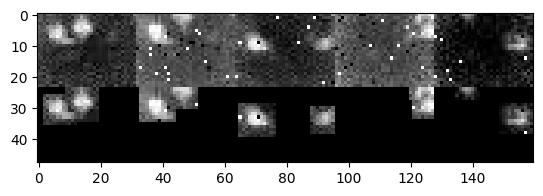

In [57]:
imgs = np.concatenate([train_images[2000:2005], train_target[2000:2005]], axis = 1)
print(imgs.shape)

plt.imshow(imgs.transpose(1, 0, 2, 3).reshape(48, -1, 1), cmap = 'gray')
plt.show()

In [58]:
from keras.layers import Dense, Input, MaxPool2D, Conv2D, Conv2DTranspose, Flatten, Reshape, Activation
from keras.layers import BatchNormalization, Dropout, Activation, concatenate
from keras.models import Model
# 24, 32, 1
def AutoEncoder():
    inputs = Input(shape=(24, 32, 1))
    x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(inputs)
    x = Conv2D(filters = 64, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
    x = Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
    x = Flatten()(x)
    latent_vector = Dense(units = 10)(x)

    x = Dense(3 * 4 * 128)(latent_vector)
    x = Reshape(target_shape=(3, 4, 128))(x)
    x = Conv2DTranspose(filters = 128, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
    x = Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu')(x)
    x = Conv2DTranspose(filters = 32, kernel_size = 3, strides = 2, padding = 'same', activation = 'sigmoid')(x)
    outputs = Conv2DTranspose(filters = 1, kernel_size = 3, padding = 'same', activation = 'sigmoid')(x)

    return Model(inputs , outputs)

In [59]:
model = AutoEncoder()
model.summary()

2023-11-02 01:20:59.831366: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-02 01:20:59.831396: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-11-02 01:20:59.831456: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-11-02 01:20:59.831897: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-02 01:20:59.832709: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 12, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 10)                15370     
                                                                 
 dense_1 (Dense)             (None, 1536)              16896 

In [60]:
model.compile(
    loss = 'mse',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [61]:
hist = model.fit(
    train_images,
    train_target,
    validation_data = (
        test_images,
        test_target
    ),
    epochs = 50,
    verbose = 1
)

Epoch 1/50


2023-11-02 01:21:09.567877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - ETA: 0s - loss: 0.0428 - accuracy: 0.8083

2023-11-02 01:21:13.363873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - 5s 19ms/step - loss: 0.0428 - accuracy: 0.8083 - val_loss: 0.0187 - val_accuracy: 0.8300
Epoch 2/50
203/203 [==============================] - 3s 15ms/step - loss: 0.0110 - accuracy: 0.8409 - val_loss: 0.0070 - val_accuracy: 0.8309
Epoch 3/50
203/203 [==============================] - 3s 15ms/step - loss: 0.0053 - accuracy: 0.8416 - val_loss: 0.0046 - val_accuracy: 0.8314
Epoch 4/50
203/203 [==============================] - 3s 15ms/step - loss: 0.0042 - accuracy: 0.8417 - val_loss: 0.0039 - val_accuracy: 0.8315
Epoch 5/50
203/203 [==============================] - 3s 15ms/step - loss: 0.0038 - accuracy: 0.8418 - val_loss: 0.0035 - val_accuracy: 0.8315
Epoch 6/50
203/203 [==============================] - 3s 15ms/step - loss: 0.0035 - accuracy: 0.8418 - val_loss: 0.0034 - val_accuracy: 0.8315
Epoch 7/50
203/203 [==============================] - 3s 15ms/step - loss: 0.0033 - accuracy: 0.8418 - val_loss: 0.0032 - val_accuracy: 0.8315
Epoch 8/50

1/1 [==============================] - 0s 148ms/step


2023-11-02 01:23:47.953887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


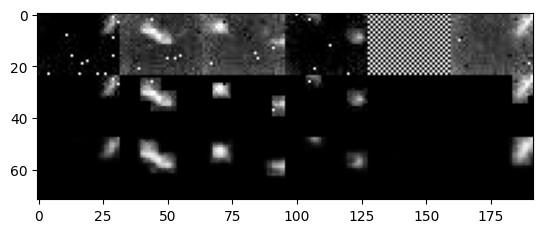

In [62]:
res = model.predict(test_images[:6])

images = np.concatenate([test_images[:6],  test_target[:6], res[:6]], axis = 1).transpose(1, 0, 2, 3).reshape(72, -1, 1)

plt.imshow(images, cmap='gray')
plt.show()

1/1 [==============================] - 0s 81ms/step


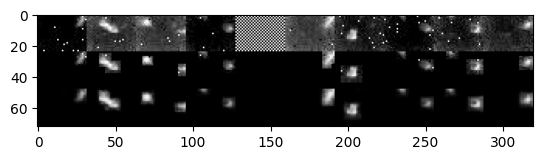

In [63]:
res = model.predict(test_images[:10])

# images = np.concatenate([test_images[:10],  test_labels[:10], res[:10]], axis = 1).transpose(1, 0, 2, 3).reshape(72, -1, 1)

images = np.concatenate([test_images[:10],  test_target[:10], res[:10]], axis = 1).transpose(1, 0, 2, 3).reshape(72, -1, 1)

plt.imshow(images, cmap='gray')
plt.show()

1/1 [==============================] - 0s 19ms/step


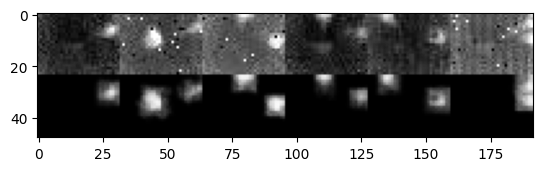

In [64]:
res = model.predict(test_images[9:15])

images = np.concatenate([test_images[9:15], res[:]], axis = 1).transpose(1, 0, 2, 3).reshape(48, -1, 1)

plt.imshow(images, cmap='gray')
plt.show()

In [103]:
from keras.layers import GRU, Dense, Input, Conv2D, Reshape
from keras.models import Model

def Sequence():
    model.trainable = False
    x = model.layers[-1].output
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), strides=(4, 4), activation='relu', padding='same')(x) 

    x = Reshape((6, 8*64))(x)  # 6x(8*64) 형태로 변환

    # GRU 계층
    x = GRU(64, return_sequences=True)(x)
    x = GRU(64)(x)

    # 출력 계층 (사람 수 예측)
    output = Dense(5, activation='softmax')(x)

    sequence_model = Model(inputs = model.input, outputs = output)
    return sequence_model

In [104]:
sequence_model = Sequence()
sequence_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 12, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 10)                15370     
                                                                 
 dense_1 (Dense)             (None, 1536)              1689

[1 1 1 1 1 1 1 1]


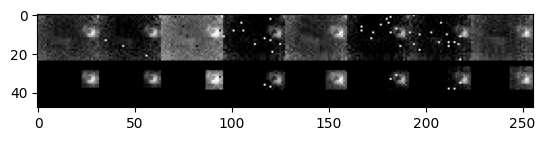

In [105]:
imgs = np.concatenate([origin_images[6600:6608], target_images[6600:6608]], axis = 1)
print(number_labels[6600:6608])

plt.imshow(imgs.transpose(1, 0, 2, 3).reshape(48, -1, 1), cmap = 'gray')
plt.show()

In [106]:
from keras.utils import to_categorical

trian_labels = to_categorical(number_labels, num_classes=5)


In [107]:
print(trian_labels.shape)

(6609, 5)


In [108]:
sequence_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [109]:
sequence_model.fit(
    origin_images, 
    trian_labels, 
    epochs=100
)


Epoch 1/100


2023-11-02 02:06:43.246995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 02:06:43.561987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 02:06:43.642556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 02:06:43.888062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 02:06:43.980303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


207/207 [==============================] - 8s 27ms/step - loss: 0.3774 - accuracy: 0.8511
Epoch 2/100
207/207 [==============================] - 5s 24ms/step - loss: 0.1175 - accuracy: 0.9535
Epoch 3/100
207/207 [==============================] - 5s 25ms/step - loss: 0.0817 - accuracy: 0.9709
Epoch 4/100
207/207 [==============================] - 5s 24ms/step - loss: 0.0604 - accuracy: 0.9803
Epoch 5/100
207/207 [==============================] - 5s 24ms/step - loss: 0.0526 - accuracy: 0.9840
Epoch 6/100
207/207 [==============================] - 5s 24ms/step - loss: 0.0438 - accuracy: 0.9858
Epoch 7/100
207/207 [==============================] - 5s 24ms/step - loss: 0.0388 - accuracy: 0.9864
Epoch 8/100
207/207 [==============================] - 5s 24ms/step - loss: 0.0280 - accuracy: 0.9912
Epoch 9/100
207/207 [==============================] - 5s 24ms/step - loss: 0.0315 - accuracy: 0.9890
Epoch 10/100
207/207 [==============================] - 5s 24ms/step - loss: 0.0213 - accuracy

In [110]:
sequence_model.save('./sequence_model.h5')

2023-11-02 02:16:04.106763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 02:16:04.242668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 02:16:04.294447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 34ms/step


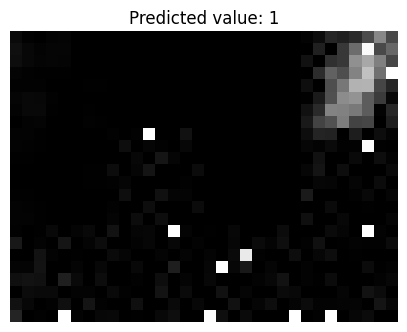

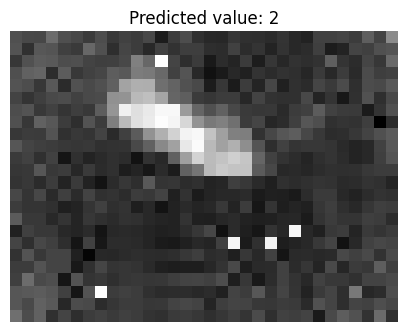

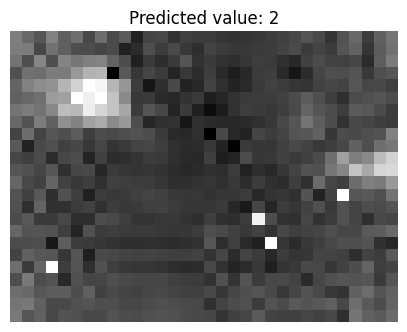

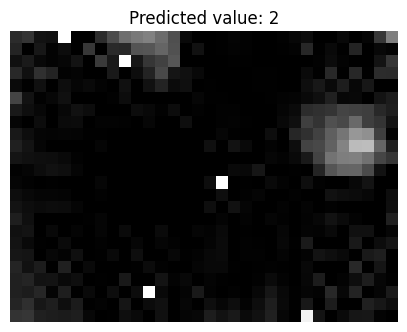

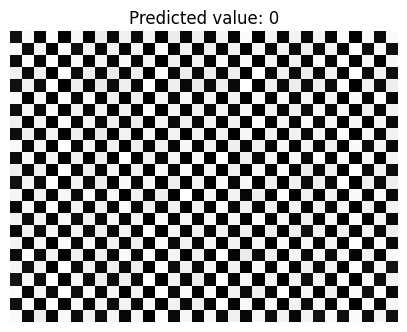

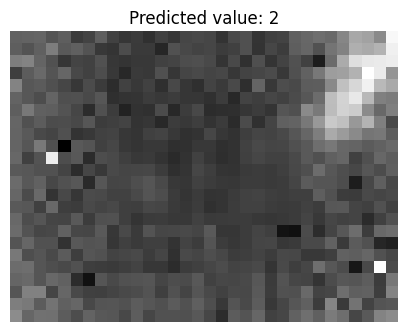

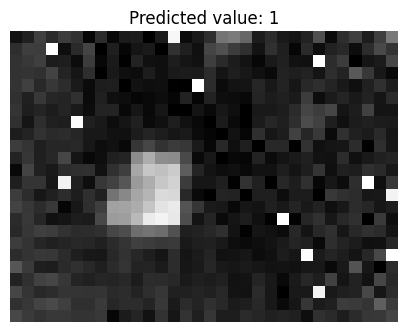

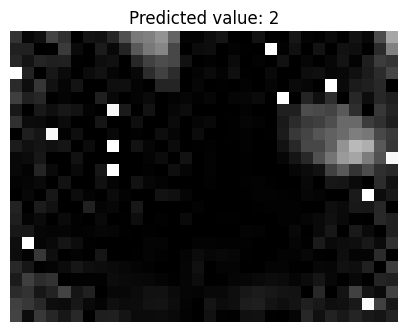

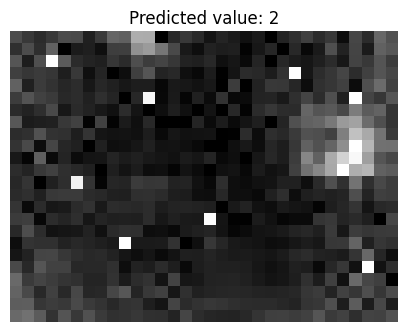

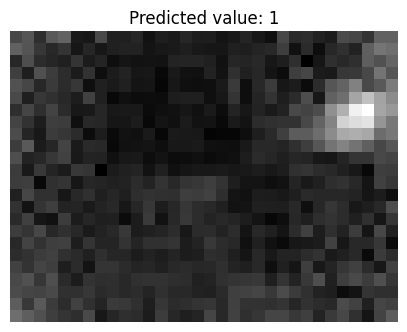

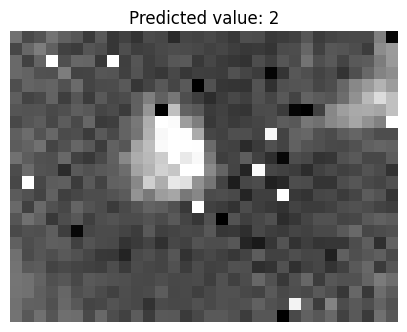

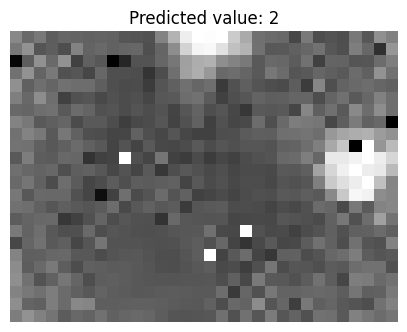

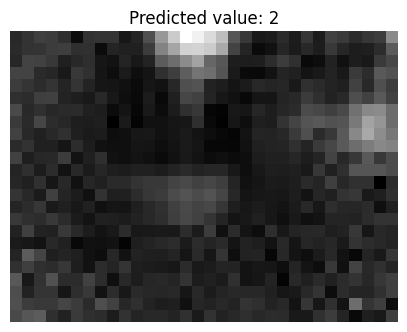

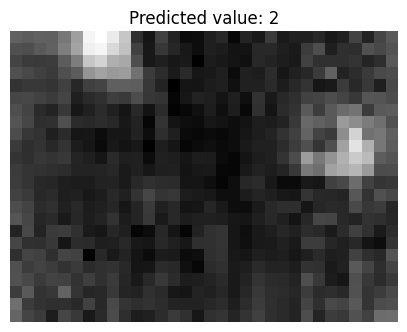

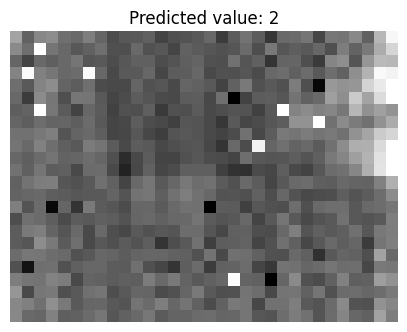

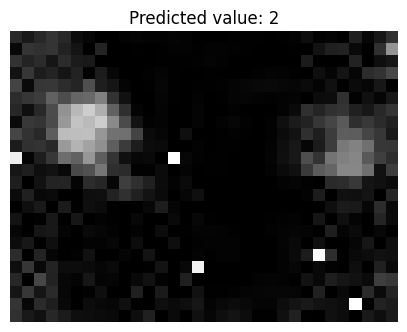

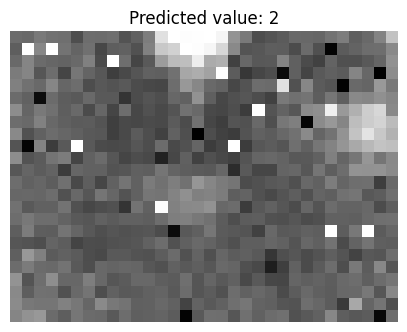

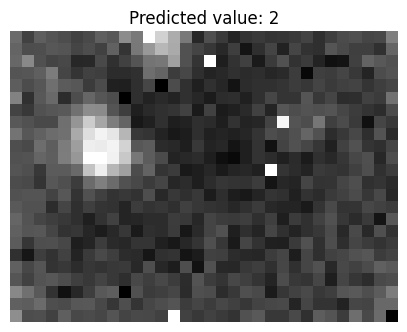

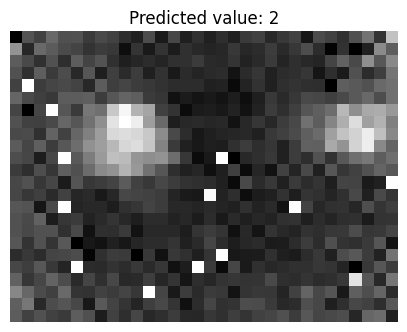

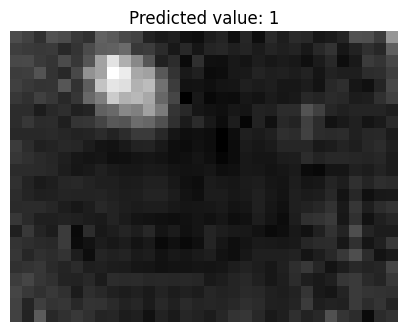

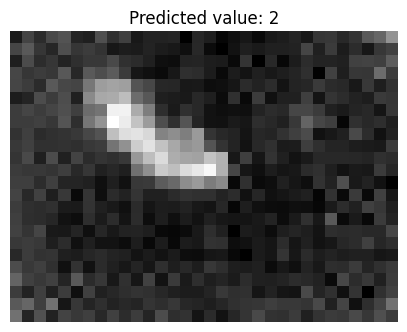

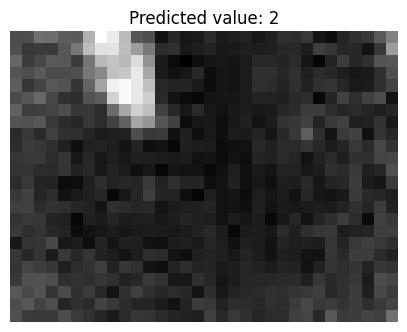

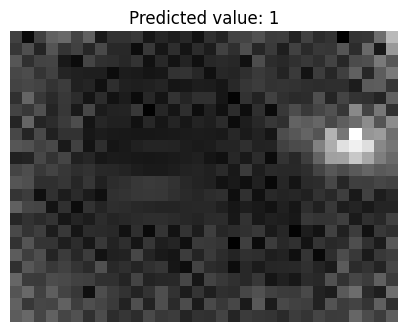

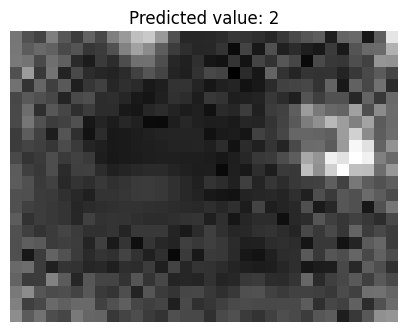

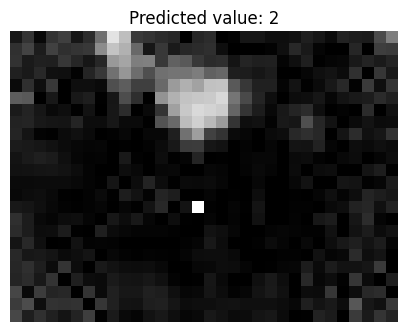

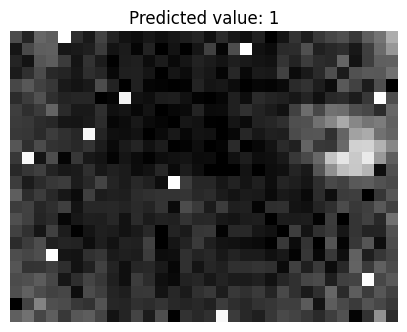

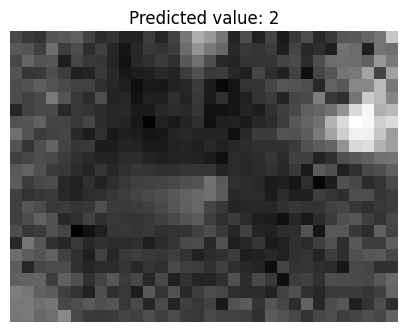

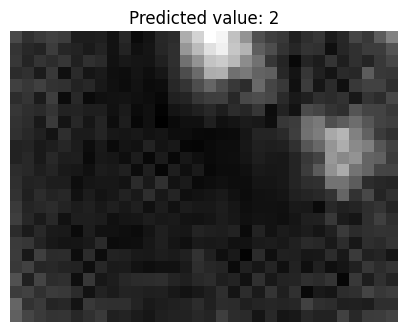

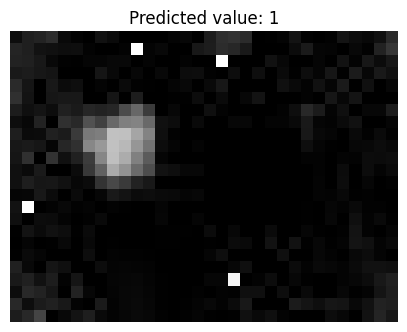

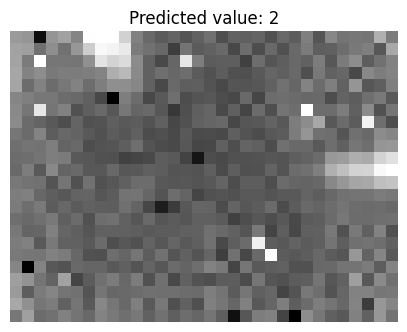

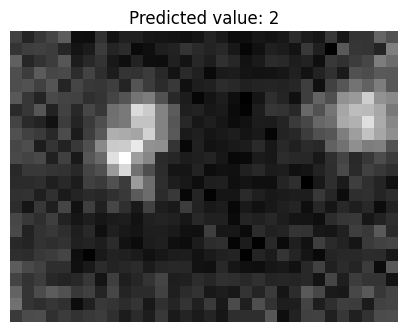

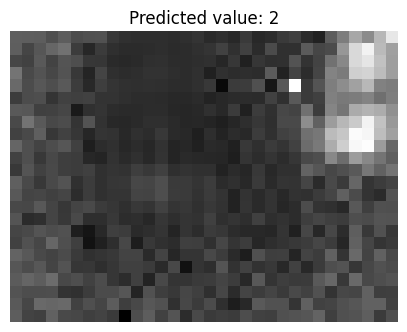

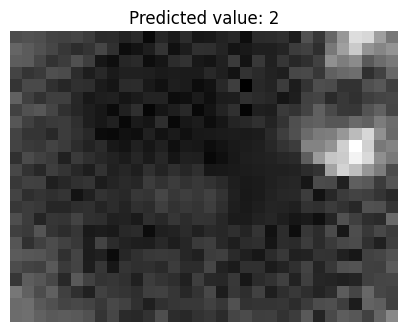

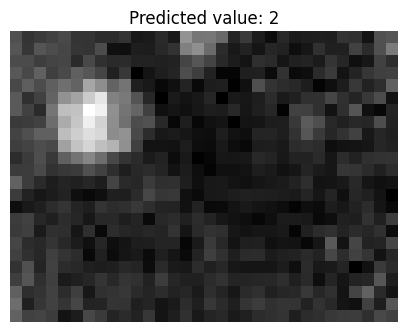

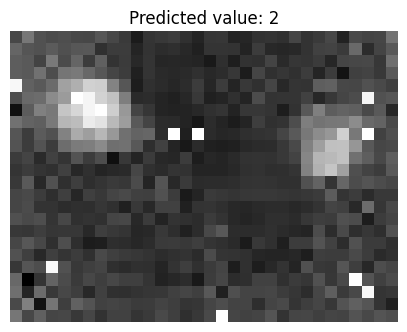

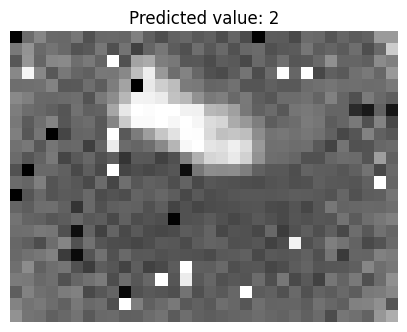

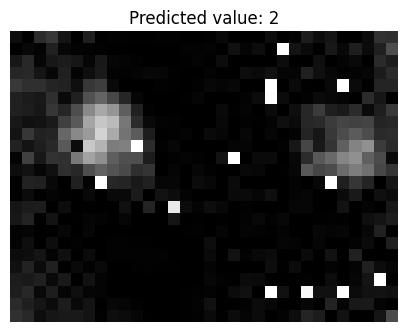

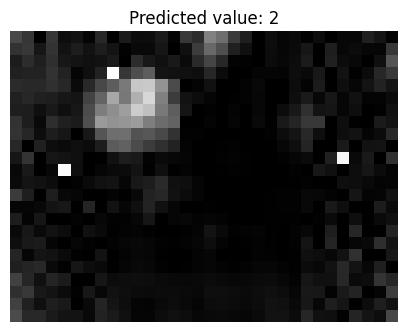

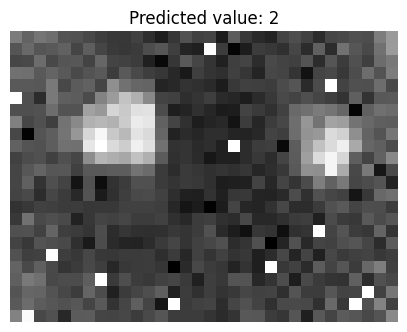

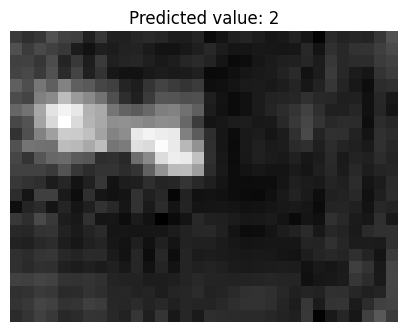

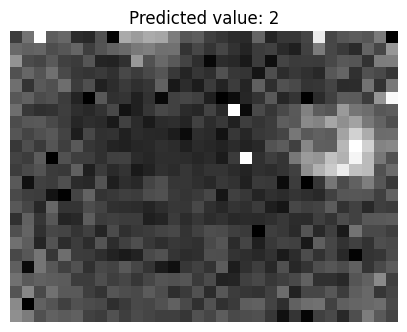

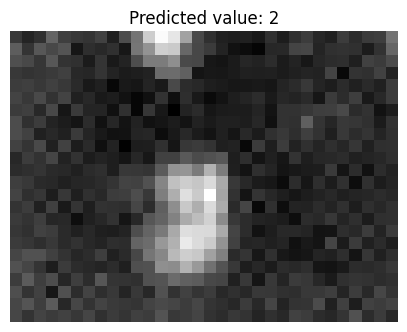

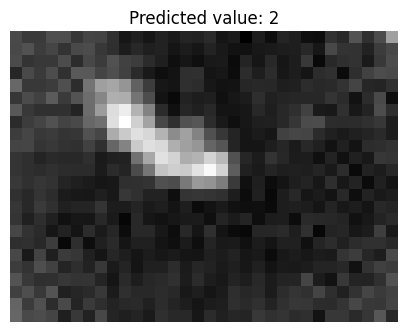

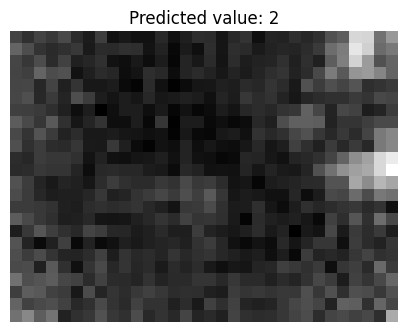

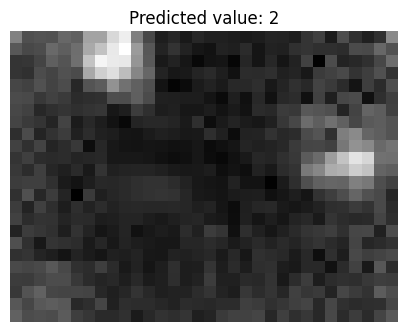

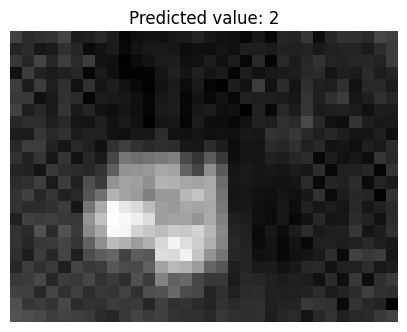

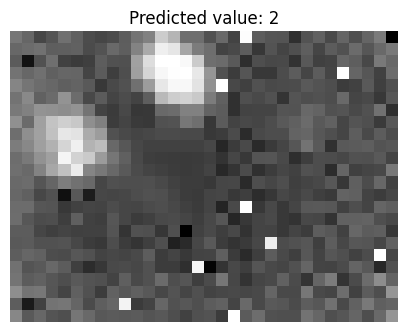

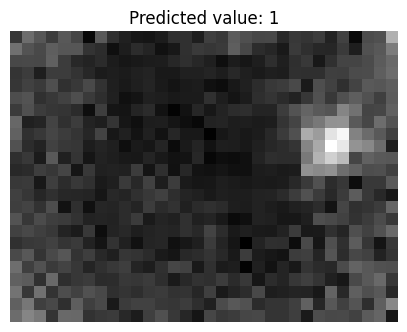

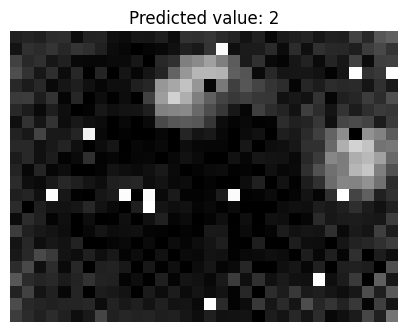

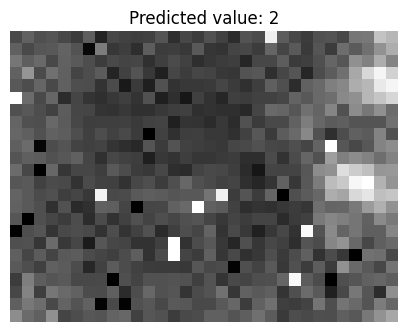

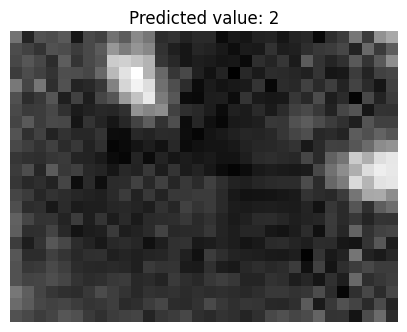

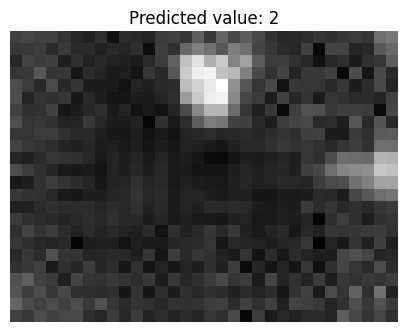

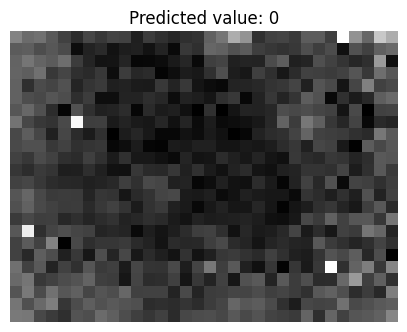

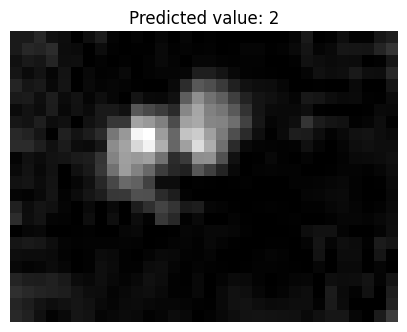

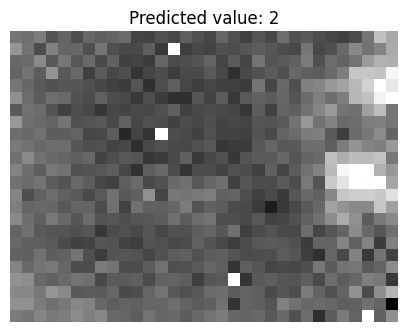

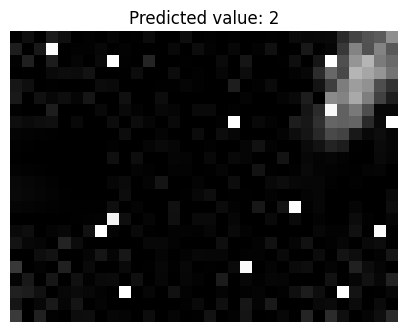

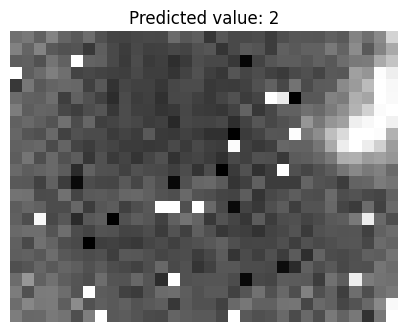

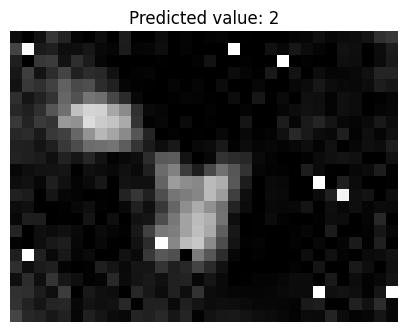

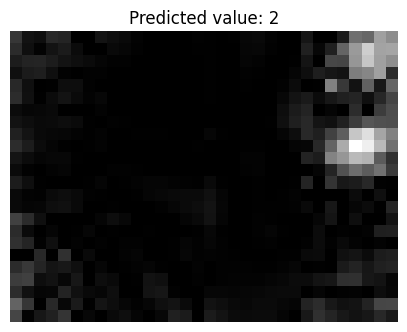

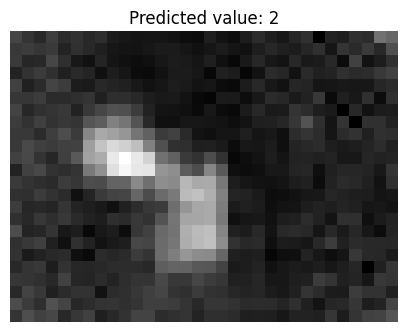

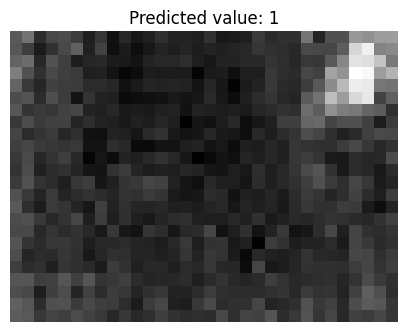

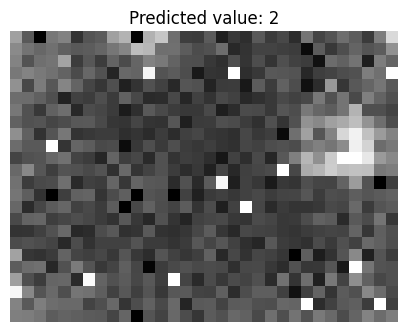

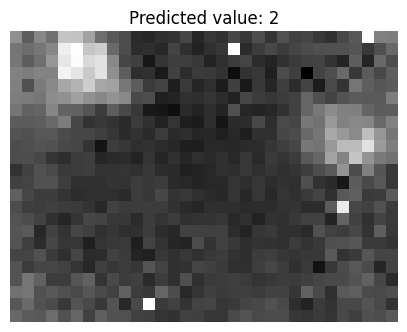

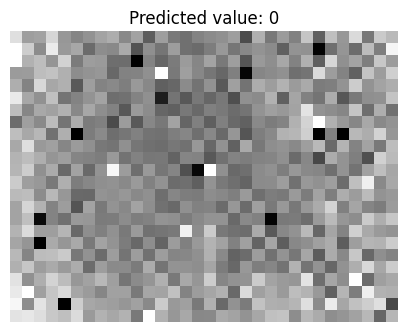

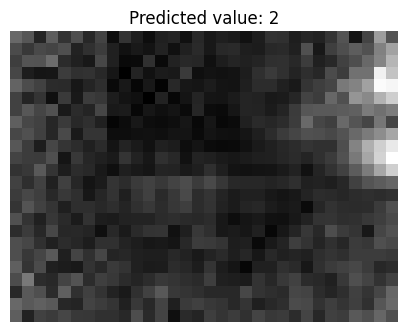

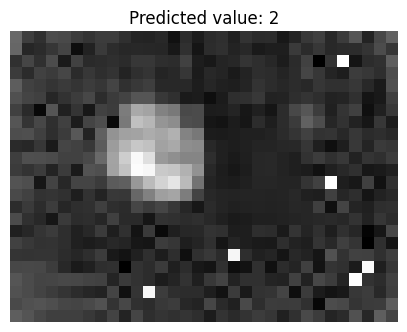

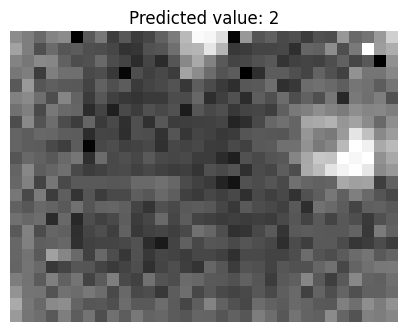

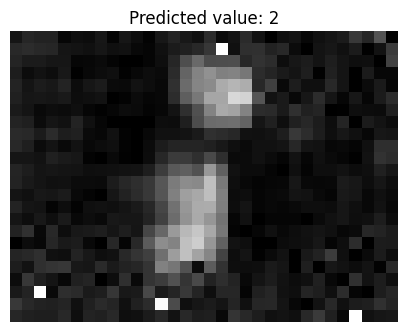

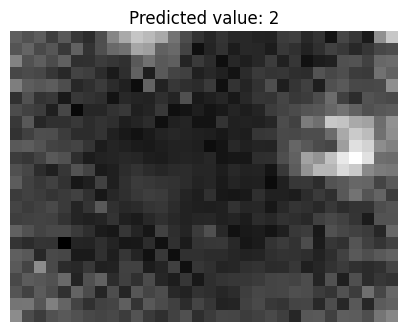

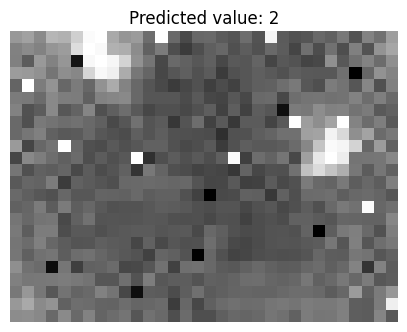

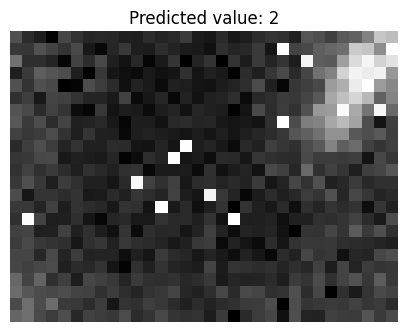

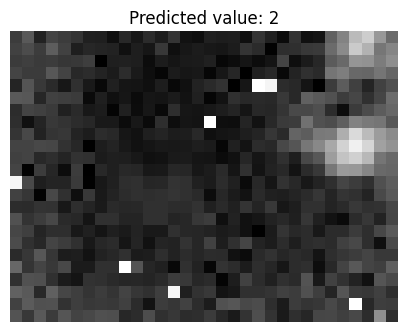

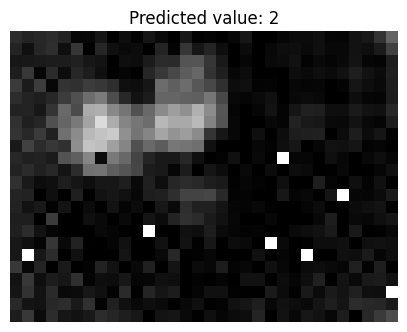

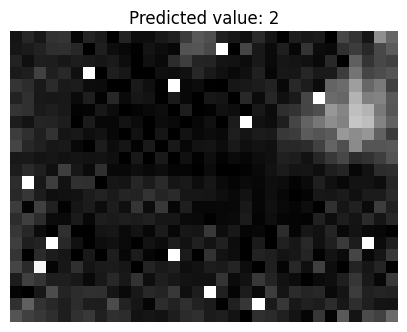

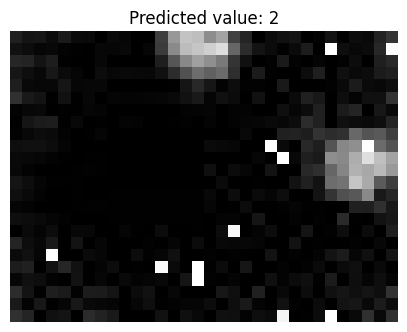

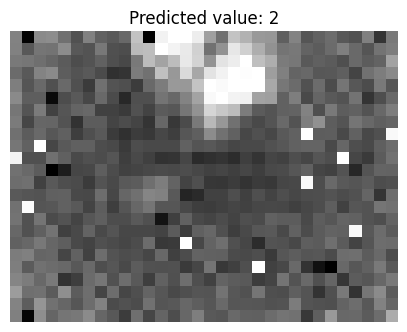

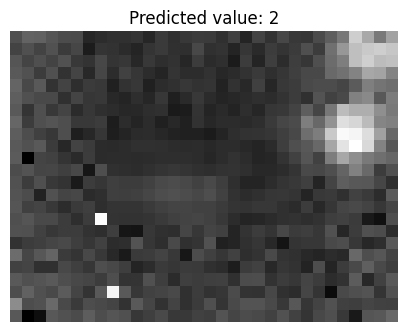

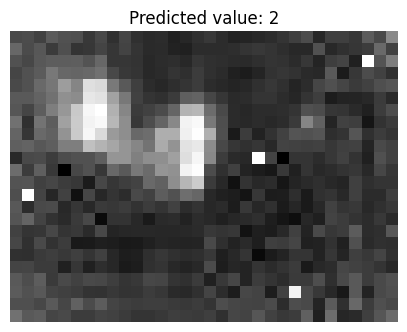

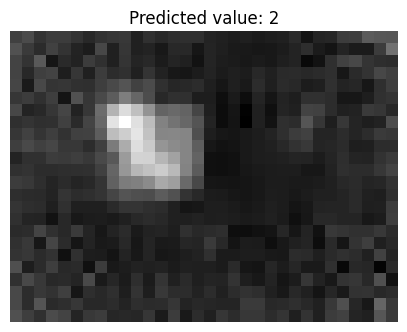

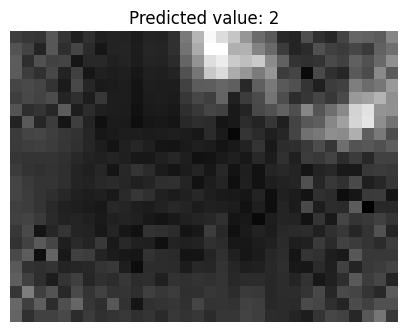

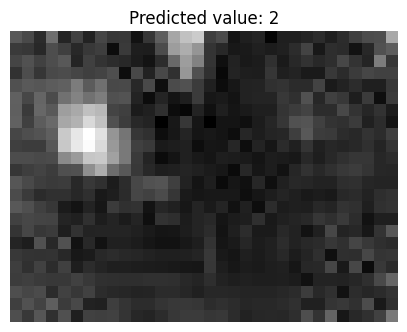

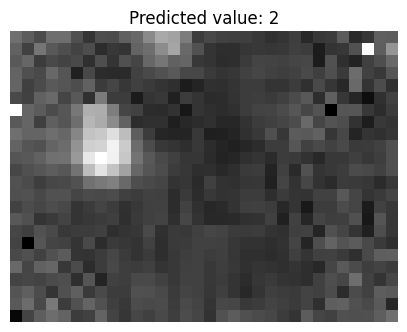

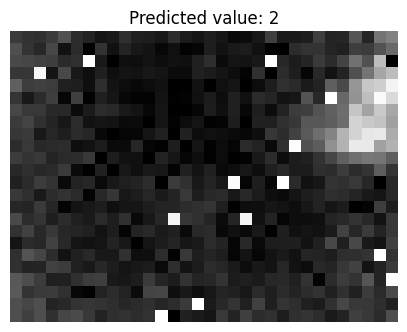

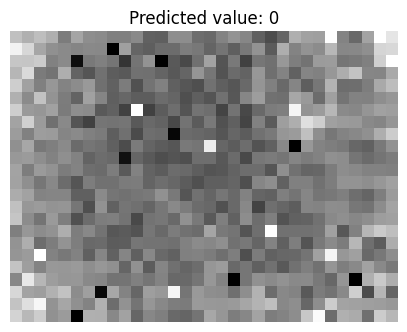

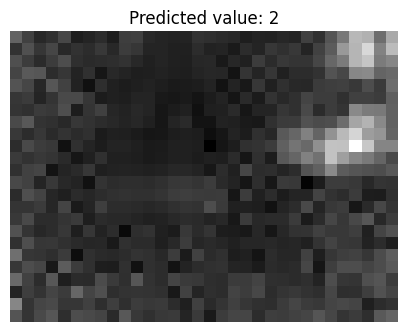

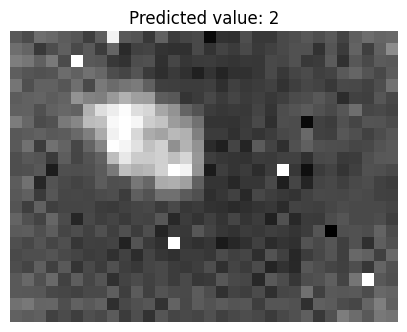

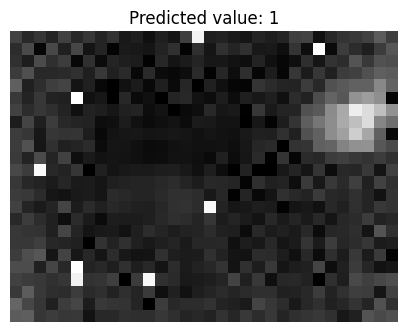

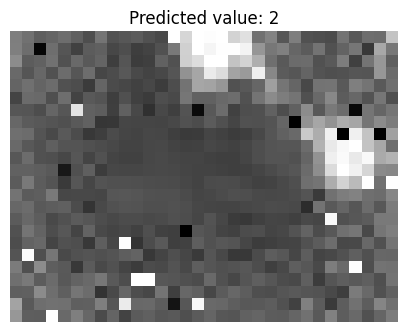

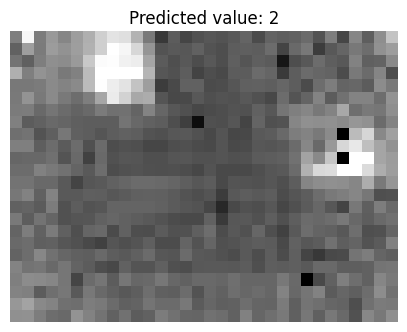

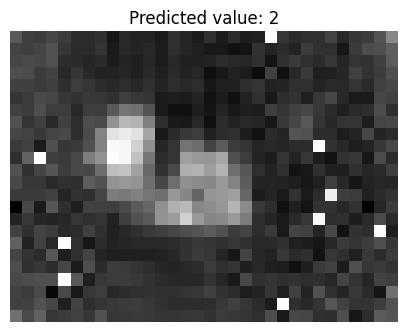

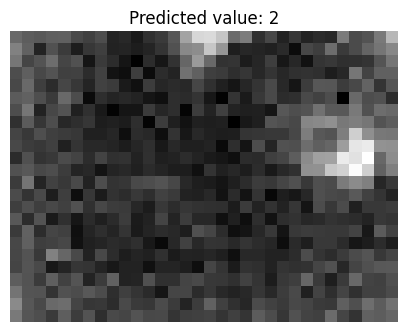

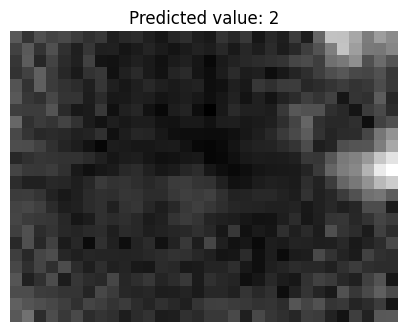

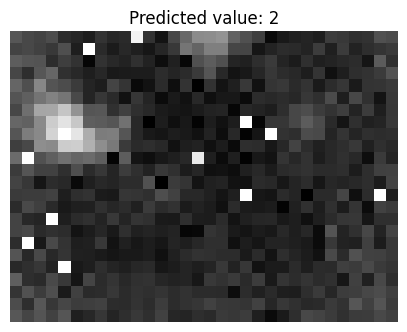

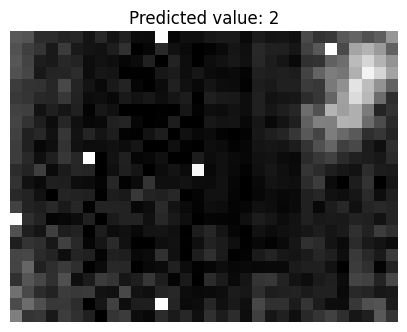

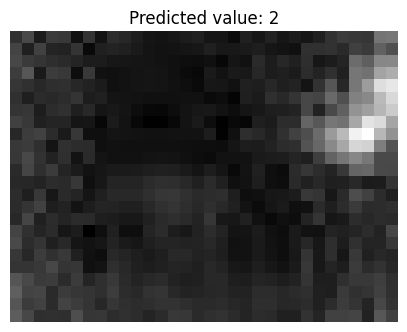

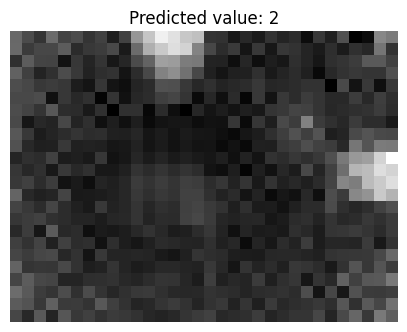

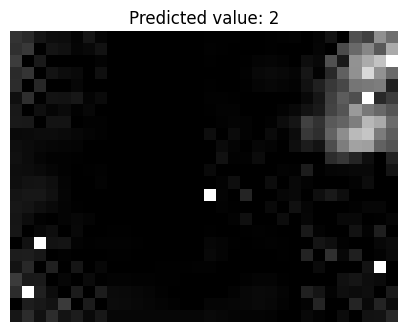

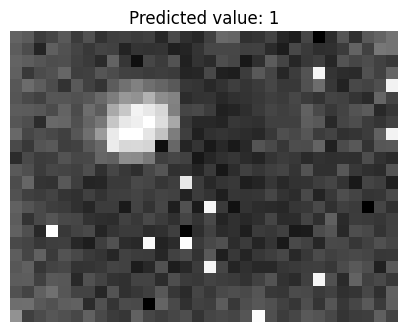

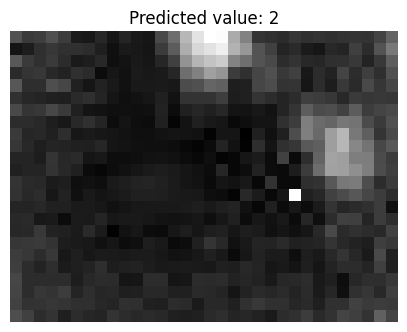

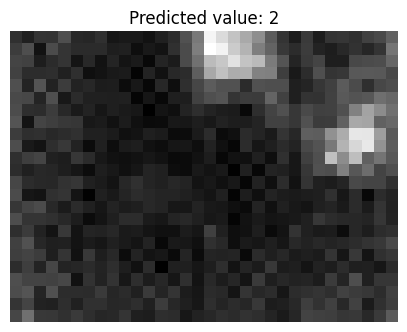

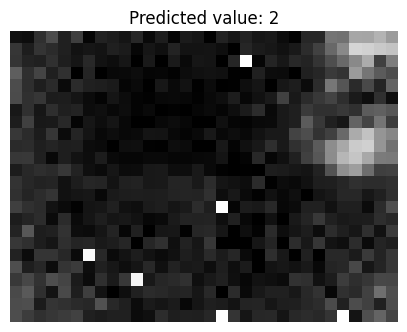

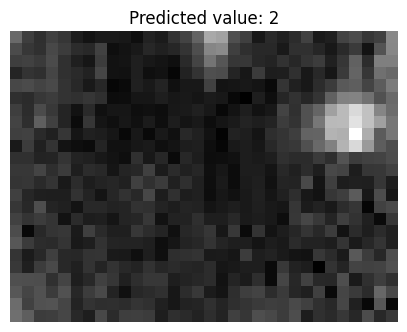

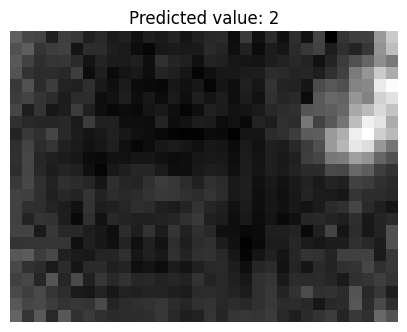

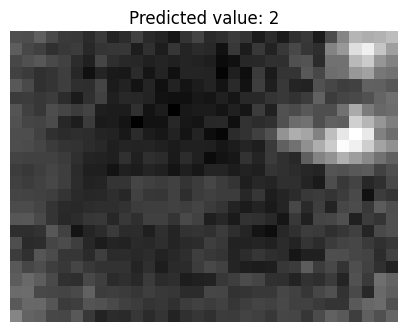

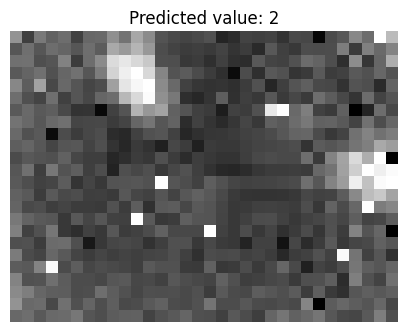

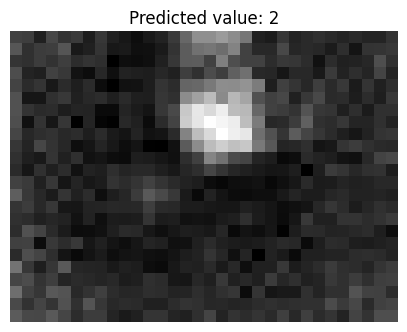

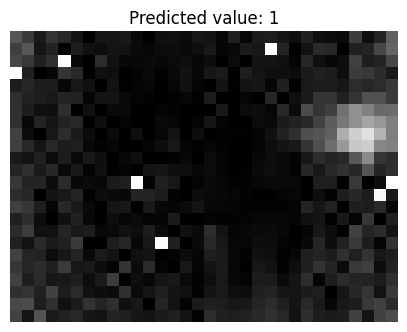

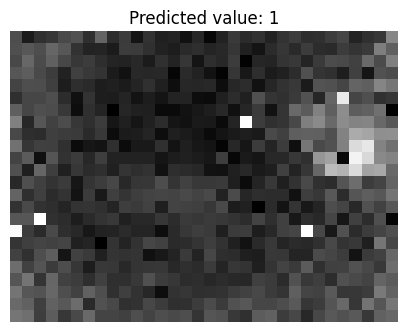

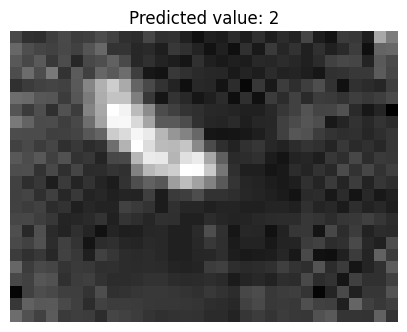

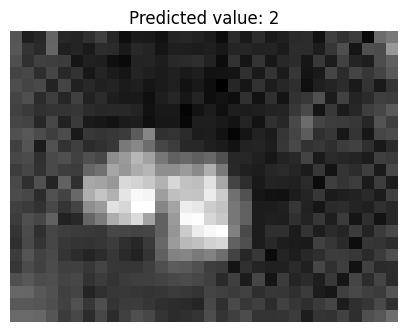

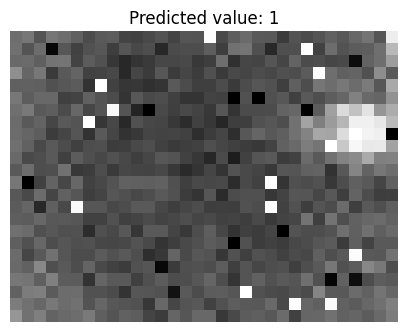

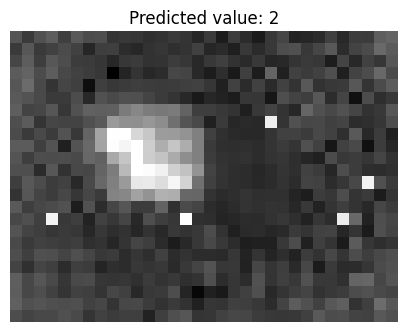

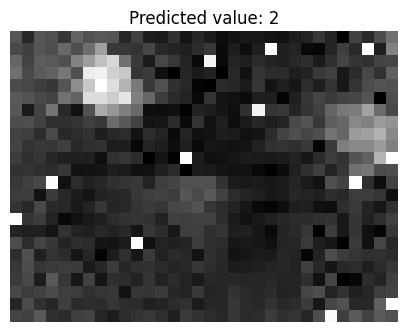

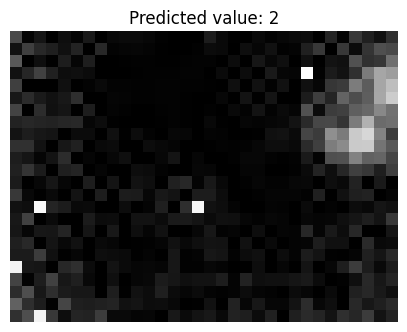

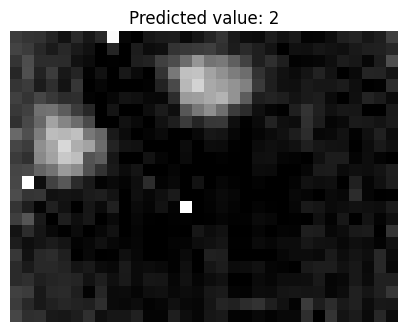

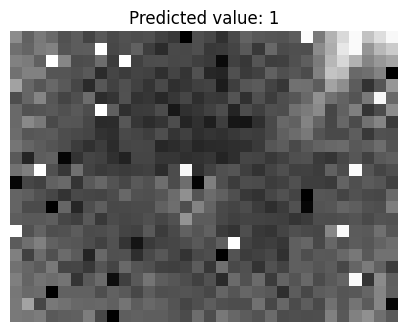

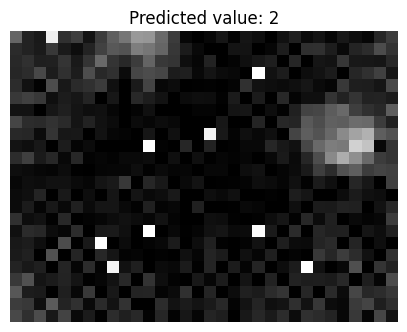

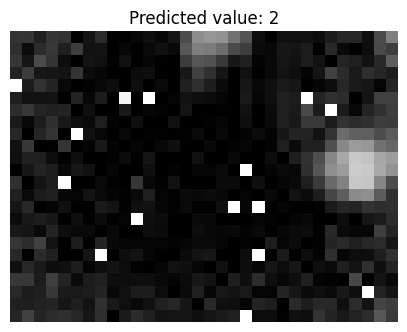

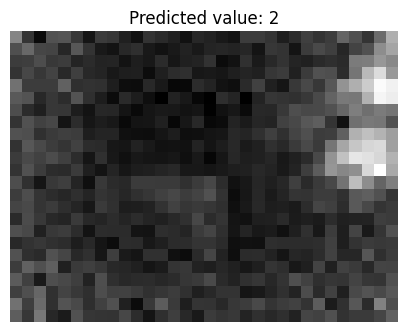

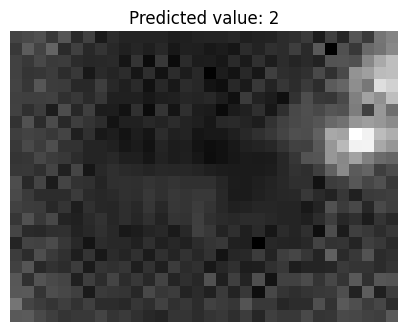

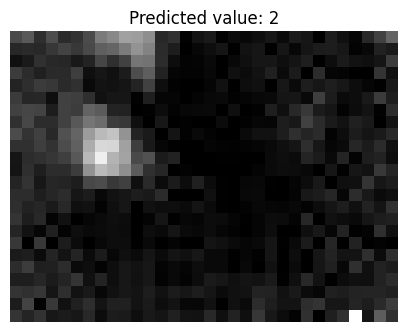

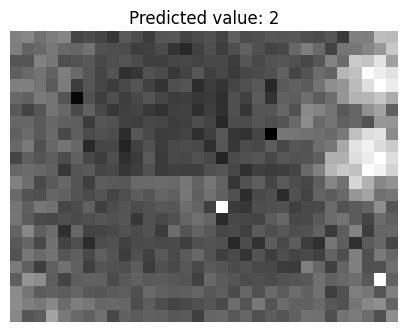

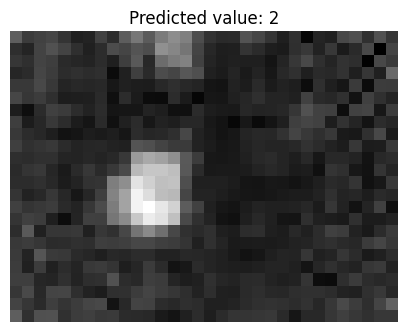

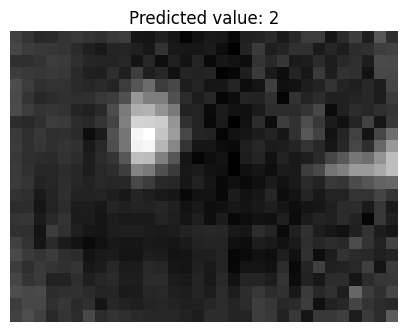

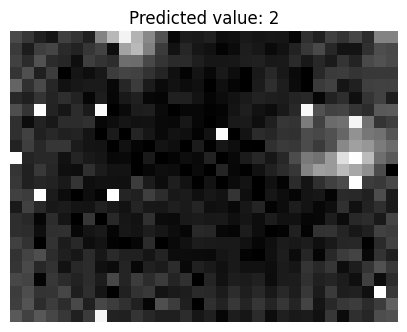

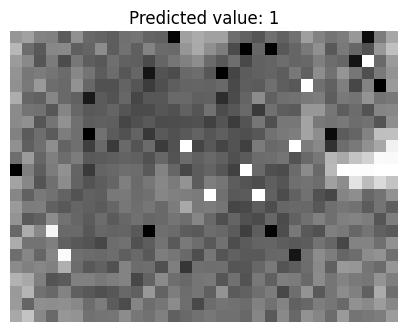

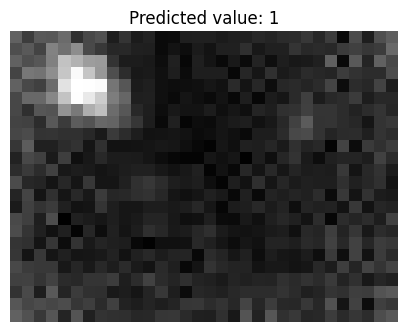

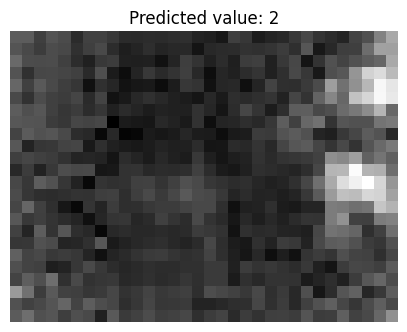

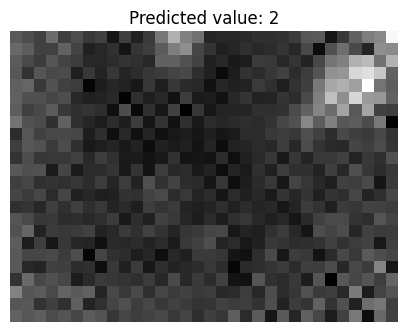

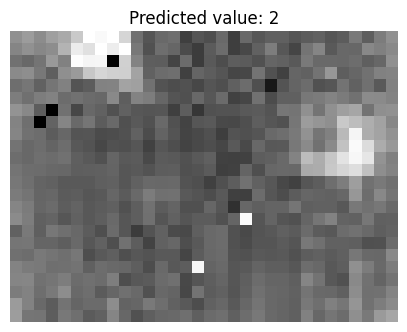

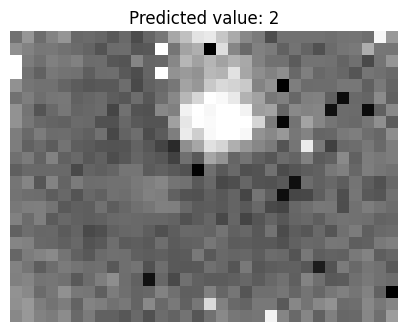

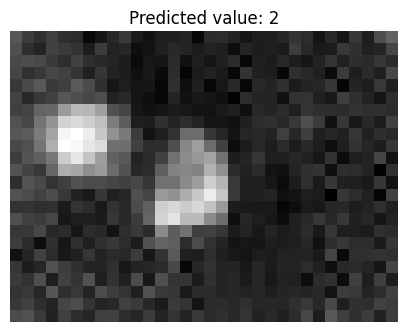

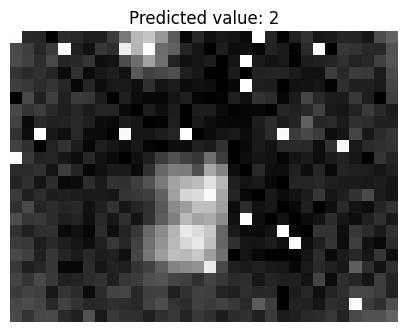

In [111]:
import matplotlib.pyplot as plt

# 예측 실행
predictions = sequence_model.predict(test_images)

# 예측 결과와 원본 이미지를 보여주기
for idx in range(len(test_images)):
    plt.figure(figsize=(5, 5))
    plt.imshow(test_images[idx].squeeze(), cmap='gray' if test_images.shape[-1] == 1 else None)  # 이미지 출력
    plt.title(f"Predicted value: {predictions[idx].argmax()}")  # 예측 값 출력
    plt.axis('off')
    plt.show()


In [ ]:
res = sequence_model.predict(test_images)
for i in range(len(test_images)):
    print(res[i].argmax())

